<a href="https://colab.research.google.com/github/Sofigam00s/Aprendizaje-Automatico-2-IA/blob/main/Gamallo_RL_TP1_entorno_discreto_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

**Alumna:** Sofia Antonia Gamallo

## Instalar librerias

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Reproducibilidad

In [2]:
# 🔒 Control total de aleatoriedad
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Asegurar determinismo en PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Crear el entorno

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
env.reset(seed=42)
env.action_space.seed(42)
env.observation_space.seed(42)
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [4]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [5]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [6]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [7]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [8]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.015
Episodio 400: Tasa de éxito = 0.013
Episodio 600: Tasa de éxito = 0.012
Episodio 800: Tasa de éxito = 0.011
Episodio 1000: Tasa de éxito = 0.009

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.009
Recompensa promedio: 0.009


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

In [9]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización

In [10]:
politica_aleatoria

array([3, 1, 1, 2, 3, 1, 3, 0, 0, 1, 3, 1, 3, 3, 2, 2])

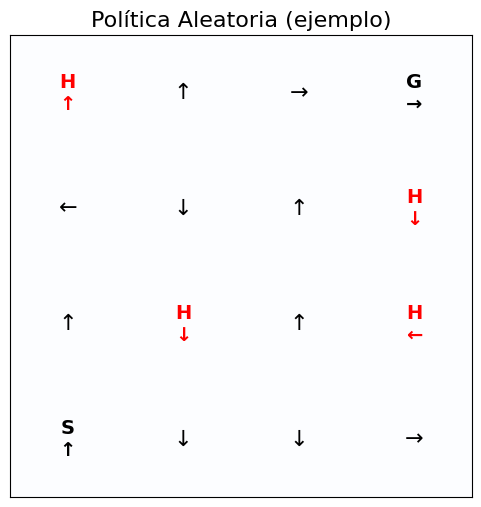

In [11]:

visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [12]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [13]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.510, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [14]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.624
Pasos promedio: 35.3


## Visualizar política aprendida

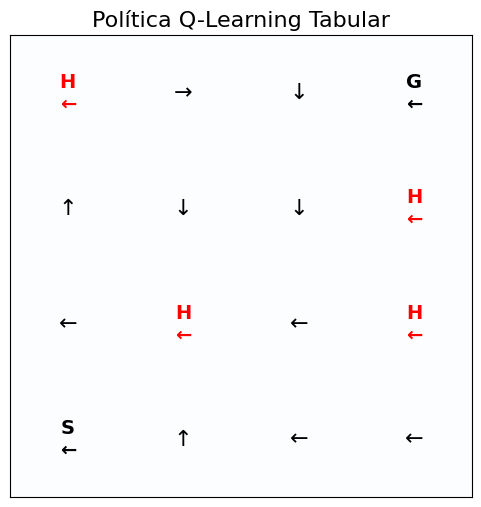

In [15]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

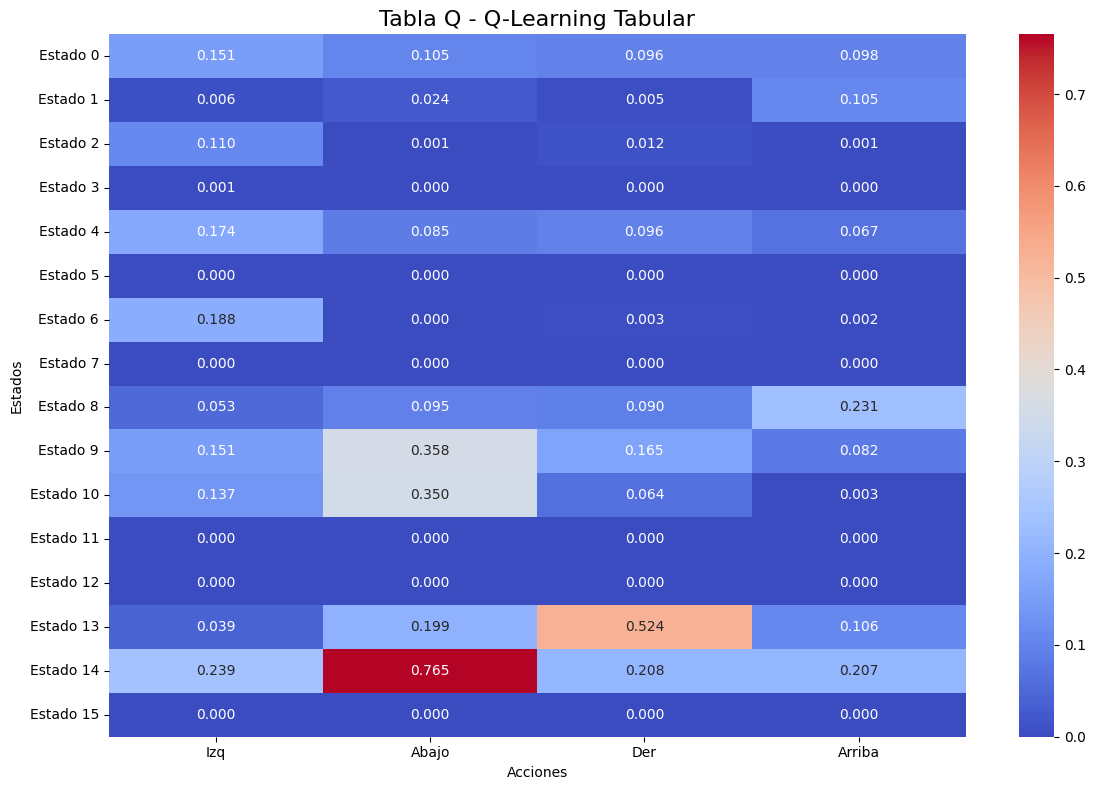

In [16]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [17]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [18]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [19]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [20]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.060, Epsilon = 0.367, Loss = 0.0078
Episodio 400: Tasa éxito = 0.220, Epsilon = 0.135, Loss = 0.0066
Episodio 600: Tasa éxito = 0.390, Epsilon = 0.049, Loss = 0.0073
Episodio 800: Tasa éxito = 0.450, Epsilon = 0.018, Loss = 0.0081
Episodio 1000: Tasa éxito = 0.620, Epsilon = 0.010, Loss = 0.0069

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [21]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.745
Pasos promedio: 40.4


## Visualizar política aprendida

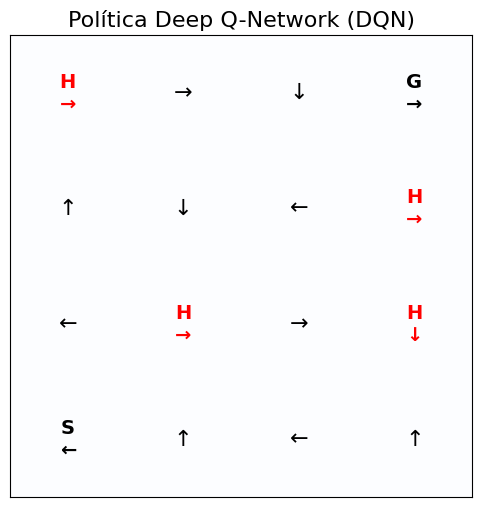

In [22]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [23]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.009
Q-Learning Tabular:    Tasa de éxito = 0.624
Deep Q-Network (DQN):  Tasa de éxito = 0.745


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [24]:
len(recompensas_aleatorio)

1000

In [25]:
len(recompensas_qlearning)

1000

In [26]:
len(recompensas_dqn)

1000

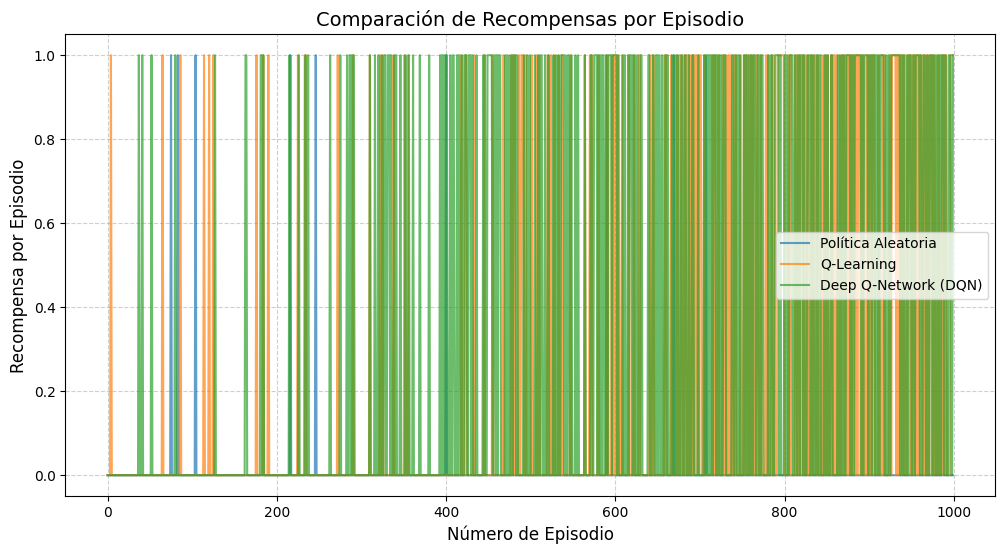

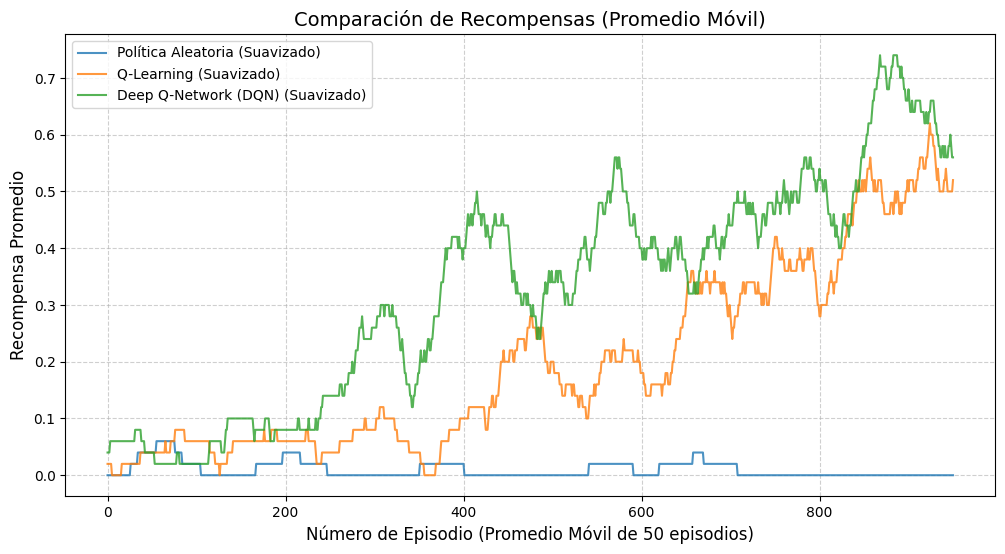

In [27]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

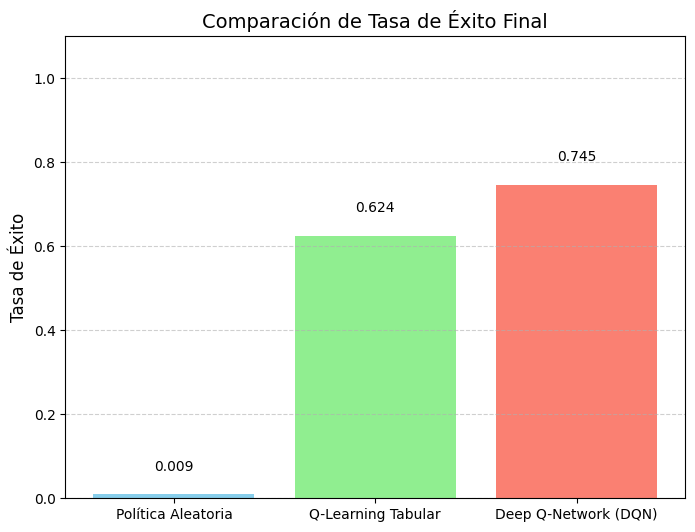

In [28]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

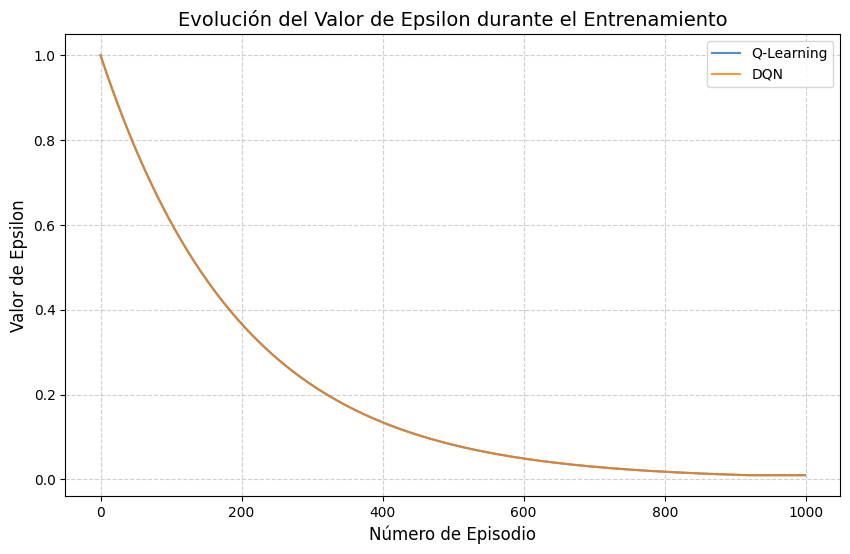

In [29]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

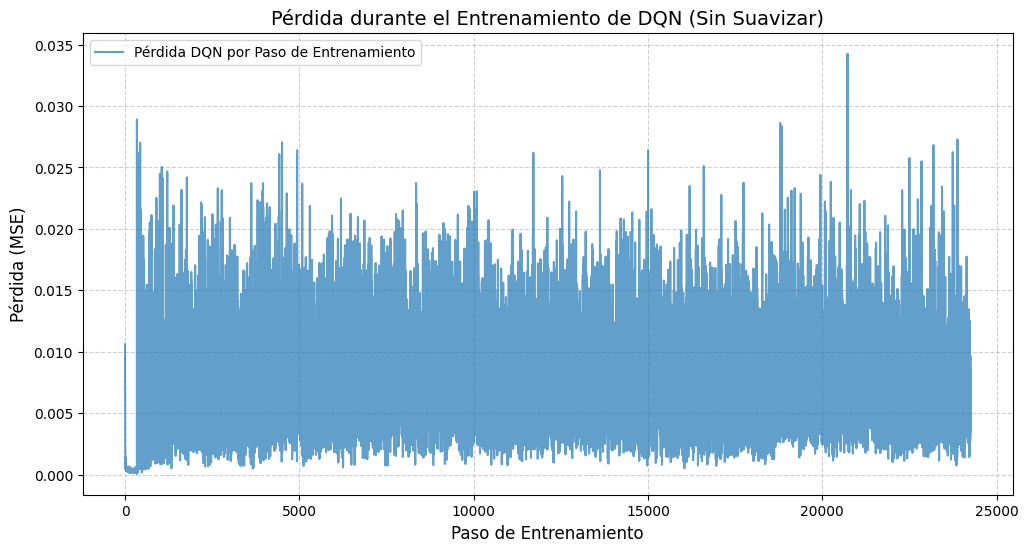

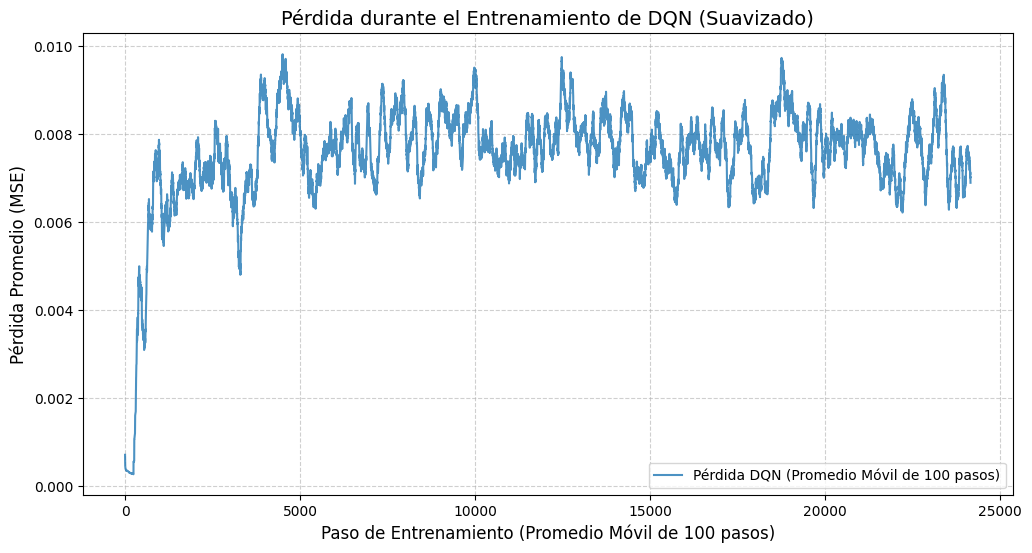

In [30]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






Para el primer punto utilicé un bucle for para que recorra los tres modelos (utilicé las vairables que se guardaron anteriormente para entrenar y evaluar cada uno) y se entrenen con los episodios 1000, 2000, 3000 y 4000. Lo hice de esta manera para comparar el desempeño en cada episodio.

También realicé dos versiones, la primera tiene el resultado real de cada episodio y la segunda está echa con un suavizado de ruido para mostrar una tendencia más general.

Iniciando el entrenamiento (cada iteración entrena con 'e' episodios y evalúa con eval_episodes)


--- ITERACIÓN: entrenando con e = 1000 episodios ---
🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.010
Episodio 400: Tasa de éxito = 0.013
Episodio 600: Tasa de éxito = 0.012
Episodio 800: Tasa de éxito = 0.009
Episodio 1000: Tasa de éxito = 0.008

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.008
Recompensa promedio: 0.008
Política Aleatoria: ENTRENADO 1000 episodios. Tasa (entrenamiento): 0.0080
🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.120, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!
Q-Learning: ENTRENADO 1000 episodios. (long recompensas: 1000)
📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.103
Pasos promedio: 14.5
Q-Learning: EVALUADO en 1000 episodios -> tasa = 0.1030
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.080, Epsilon = 0.367, Loss = 0.00

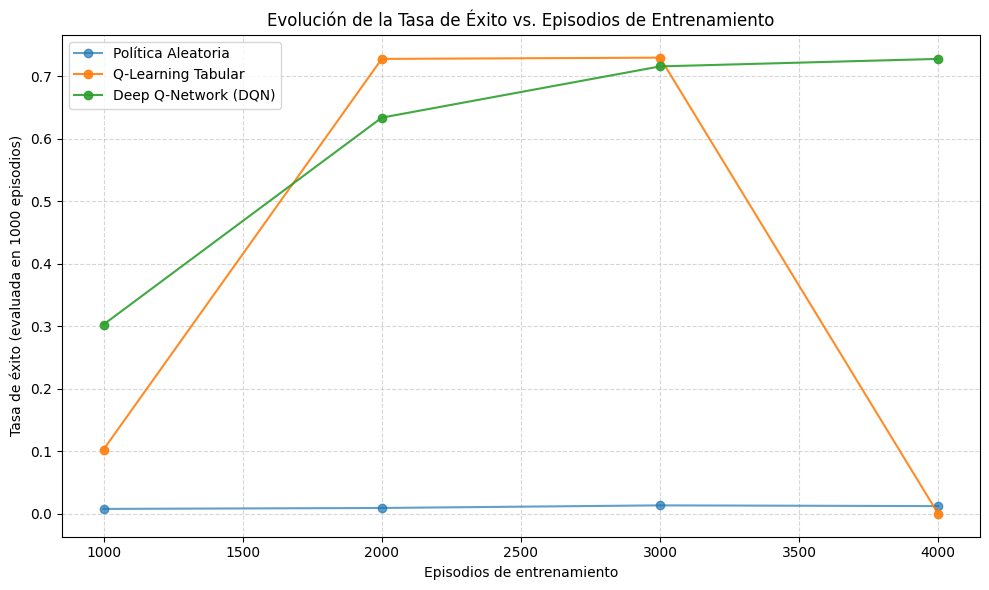

In [31]:
#Entrenamiento y evaluación real
episodios_list = list(range(1000, 5000, 1000)) #Lista para que realice 5000 episodios, y que vayan los resultados de 1000 en 1000
eval_episodes = 1000

tasas_aleatorio = []
tasas_qlearning = []
tasas_dqn = []

print("Iniciando el entrenamiento (cada iteración entrena con 'e' episodios y evalúa con eval_episodes)\n")

for e in episodios_list:
    print(f"\n--- ITERACIÓN: entrenando con e = {e} episodios ---")

    # Para la política aleatoria
    agente_aleatorio = PoliticaAleatoria(env.action_space.n)
    recompensas_a, tasa_aleatorio = agente_aleatorio.entrenar(env, episodios=e)
    print(f"Política Aleatoria: ENTRENADO {e} episodios. Tasa (entrenamiento): {tasa_aleatorio:.4f}")
    tasas_aleatorio.append(tasa_aleatorio)

    # Para Q learning tabular
    agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, epsilon=1.0)
    recompensas_q = agente_qlearning.entrenar(env, episodios=e)
    print(f"Q-Learning: ENTRENADO {e} episodios. (long recompensas: {len(recompensas_q)})")
    tasa_q, _ = agente_qlearning.evaluar(env, episodios=eval_episodes)
    print(f"Q-Learning: EVALUADO en {eval_episodes} episodios -> tasa = {tasa_q:.4f}")
    tasas_qlearning.append(tasa_q)

    # Para Deep Q learning
    agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=0.95, epsilon=1.0)
    recompensas_d = agente_dqn.entrenar(env, episodios=e)
    print(f"DQN: ENTRENADO {e} episodios. (long recompensas: {len(recompensas_d)})")
    tasa_d, _ = agente_dqn.evaluar(env, episodios=eval_episodes)
    print(f"DQN: EVALUADO en {eval_episodes} episodios -> tasa = {tasa_d:.4f}")
    tasas_dqn.append(tasa_d)

print("\n✅ Todos los entrenamientos y evaluaciones completados.")

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(episodios_list, tasas_aleatorio, marker='o', label='Política Aleatoria', alpha=0.7)
plt.plot(episodios_list, tasas_qlearning, marker='o', label='Q-Learning Tabular', alpha=0.9)
plt.plot(episodios_list, tasas_dqn, marker='o', label='Deep Q-Network (DQN)', alpha=0.9)

plt.title("Evolución de la Tasa de Éxito vs. Episodios de Entrenamiento")
plt.xlabel("Episodios de entrenamiento")
plt.ylabel(f"Tasa de éxito (evaluada en {eval_episodes} episodios)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Iniciando experimento con suavizado (promedio de varias corridas)


--- ENTRENANDO con 1000 episodios ---
  Corrida 1/3
🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.005
Episodio 400: Tasa de éxito = 0.005
Episodio 600: Tasa de éxito = 0.007
Episodio 800: Tasa de éxito = 0.007
Episodio 1000: Tasa de éxito = 0.009

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.009
Recompensa promedio: 0.009
🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.200, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!
📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.173
Pasos promedio: 17.8
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.010, Epsilon = 0.367, Loss = 0.0008
Episodio 400: Tasa éxito = 0.110, Epsilon = 0.135, Loss = 0.0043
Episodio 600: Tasa éxito = 0.270, Epsilon = 0.049, Loss = 0.0058
Episodio 800: Tasa éxito = 0.350, Epsilon = 0.018, Loss = 0.0069
Episodio 1000: Tasa éxito = 

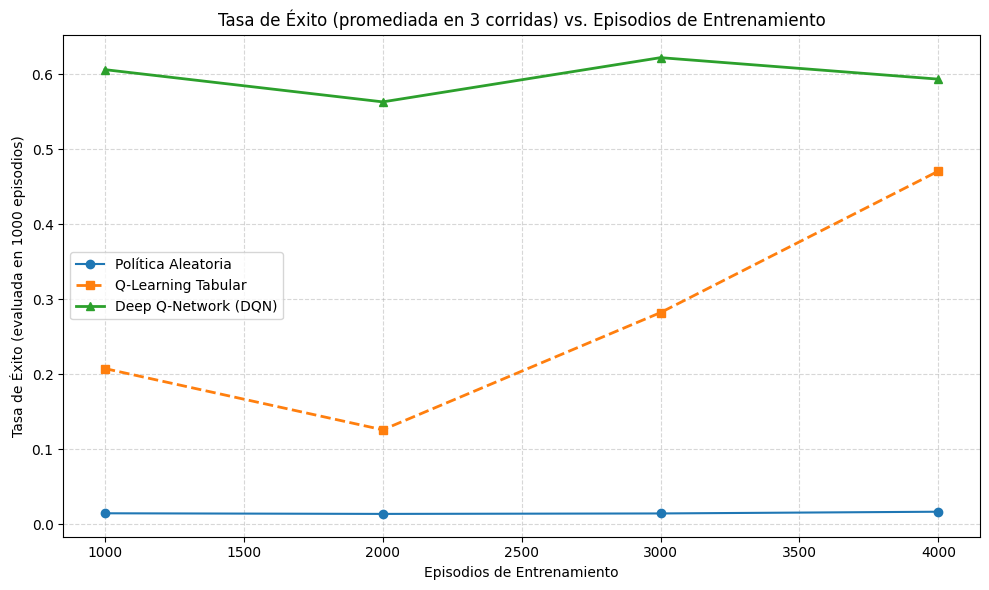

In [32]:
#Entrenamiento con suavizado

import numpy as np

episodios_list = list(range(1000, 5000, 1000))
eval_episodes = 1000
n_runs = 3  # cantidad de corridas para promediar

tasas_aleatorio = []
tasas_qlearning = []
tasas_dqn = []

print("Iniciando experimento con suavizado (promedio de varias corridas)\n")

for e in episodios_list:
    print(f"\n--- ENTRENANDO con {e} episodios ---")
    temp_a, temp_q, temp_d = [], [], []

    for run in range(n_runs):
        print(f"  Corrida {run+1}/{n_runs}")

        agente_aleatorio = PoliticaAleatoria(env.action_space.n)
        _, t_a = agente_aleatorio.entrenar(env, episodios=e)
        temp_a.append(t_a)

        agente_q = QLearningTabular(env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, epsilon=1.0)
        agente_q.entrenar(env, episodios=e)
        t_q, _ = agente_q.evaluar(env, episodios=eval_episodes)
        temp_q.append(t_q)

        agente_d = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=0.95, epsilon=1.0)
        agente_d.entrenar(env, episodios=e)
        t_d, _ = agente_d.evaluar(env, episodios=eval_episodes)
        temp_d.append(t_d)

    # promedio de las corridas
    tasas_aleatorio.append(np.mean(temp_a))
    tasas_qlearning.append(np.mean(temp_q))
    tasas_dqn.append(np.mean(temp_d))

print("\n✅ Suavizado por promedio completado. Graficando...")

plt.figure(figsize=(10,6))
plt.plot(episodios_list, tasas_aleatorio, 'o-', label='Política Aleatoria')
plt.plot(episodios_list, tasas_qlearning, 's--', label='Q-Learning Tabular', linewidth=2)
plt.plot(episodios_list, tasas_dqn, '^-', label='Deep Q-Network (DQN)', linewidth=2)

plt.title("Tasa de Éxito (promediada en 3 corridas) vs. Episodios de Entrenamiento")
plt.xlabel("Episodios de Entrenamiento")
plt.ylabel(f"Tasa de Éxito (evaluada en {eval_episodes} episodios)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#### Resultados:

Las dos versiones de los tres modelos mostraron resultados similares.

* Versión real:
  * El modelo aleatorio tuvo un desempeño bajo en todas iteraciones de episodios. Esto me hace pensar que deido a su política, al tomar decisiones justamente aleatorias, no logra encontrar una lógica para aprender y llegar a la meta, es como tirar la moneda y esperar que el resultado sea el correcto.
  * El modelo Q-Learning tabular mostró una mejora sostenida a medida que aumentaban los episodios, logrando incluso la mejor tasa de éxito intermedia entre los tres. Sin embargo, en la última iteración con 4000 episodios su rendimiento cayó a 0%, probablemente porque no logró equilibrar la exploración y la explotación, al dejar de explorar, se estancó en trayectorias no óptimas y perdió su capacidad de adaptación.
  * El modelo deep q learning arrancó en 1000 episodios con una tasa de 30%, baja, pero la mejor de los tres modelos. Luego fue mejorando a medida que aumentaban los episodios lo que sugiere que su red neuronal le permitió generalizar mejor y mantener una política más estable.

* Version suavizada:
  * El modelo aleatorio sigue teniendo un desempeño pobre y sin mejora.
  * El modelo Q learning tabular tuvo un comportamiento diferente, casi lo contrario a la version real. En esta versión, primero empeora para despues mejorar poco a poco. Por otro lado, ya no tiene la tasa de éxito más alta. Esto me hace pensar que el modelo al ser un poco más simple no mantiene un equilirbio tan constante en sus resultados.
  * El modelo Deep Q learning tuvo un comportamiento un poquito diferente a la versión real, esta vez se ve más equilibrado y mantiene un desempeño alto, sus resultados para cada episodio no son tan diferentes. Parece que este modelo es más robusto y eso ayuda a mantener este equilibrio.

  **CONCLUSIÓN**
   
  Las dos versiones no tienen diferencias tan grandes, pero la versión suavizada nos permite tener un resultado más general de los modelos, lo que me ayudo a tener una persecpción más adecuada del funcionamiento de cada modelo.

  Lo que pude notar es que para la versión suavizada, a medida que aumentaban los episodios, la mejora de éxito también lo hacía. Esto significa que al agente le sirve tener más episodios para poder explorar más el entorno, aprender mejor y ajustar su política.
  También me di cuenta que el modelo aleatorio siempre obtiene un desempaño muy bajo, como dije antes, para este caso no sirve usar como política la aletoiriedad.

  De igual manera, considero que esta mejora exponencial de éxito en la versión suavizada a medida que aumentan los episodios, se dió porque el entorno que estamos usando es simple al igual que su exploración. Además, los modelos tienen sus hiperparámetros bien ajustados para este ejemplo simple. Por lo tanto, creo que es esperable que para Q learning tabular y DQN a mayor episodios, mejor desempeño.

## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

Para las consignas B y C, utilicé el mismo método; un bucle for que recorra los diferentes valores de gamma y alpha(learning rate). Voy a entrenar el modelo con 2000 episodios para que no tarde tanto en ejecutarse, pero que tanpoco tenga pocos episodios.

Para este caso, utilicé valores gamma 0.33, 0.66, 0.99 y 1.33
Elegí estos valores teniendo en cuenta que la configuración original para este modelo DQN (0.95) funcinó bastante bien. También en el tutorial de Pytorch utilizan el valor 0.99 como óptimo, así que en base a eso puse los demás valores.


🔧 Entrenando DQN con gamma = 0.33
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0036
Episodio 400: Tasa éxito = 0.020, Epsilon = 0.135, Loss = 0.0031
Episodio 600: Tasa éxito = 0.020, Epsilon = 0.049, Loss = 0.0034
Episodio 800: Tasa éxito = 0.050, Epsilon = 0.018, Loss = 0.0042
Episodio 1000: Tasa éxito = 0.080, Epsilon = 0.010, Loss = 0.0037
Episodio 1200: Tasa éxito = 0.070, Epsilon = 0.010, Loss = 0.0033
Episodio 1400: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0035
Episodio 1600: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0044
Episodio 1800: Tasa éxito = 0.020, Epsilon = 0.010, Loss = 0.0031
Episodio 2000: Tasa éxito = 0.040, Epsilon = 0.010, Loss = 0.0029

✅ Entrenamiento Deep Q-Network (DQN) completado!
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.044
Pasos promedio: 5.8

🔧 Entrenando DQN con gamma = 0.66
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tas

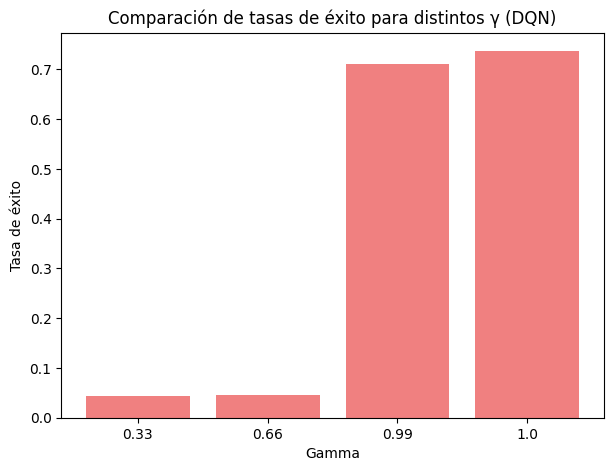

In [33]:
# Distintos valores de gamma
gammas = [0.33, 0.66, 0.99, 1.0]
tasas_gamma = []

for g in gammas:
    print(f"\n🔧 Entrenando DQN con gamma = {g}")
    agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n, lr=0.001, gamma=g, epsilon=1.0)
    recompensas_dqn = agente_dqn.entrenar(env, episodios=2000)
    tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)
    tasas_gamma.append(tasa_exito_dqn)

plt.figure(figsize=(7,5))
plt.bar([str(g) for g in gammas], tasas_gamma, color='lightcoral')
plt.title("Comparación de tasas de éxito para distintos γ (DQN)")
plt.xlabel("Gamma")
plt.ylabel("Tasa de éxito")
plt.show()


#### Resultados:

Recordando que el facor de descuento(gamma) equilibra la importancia de la recompensa actual con la futura, y además teniendo en cuenta que a más episodios el modelo DQN puede aprender mejor y ajustar su politica de manera adecuada, los resultados tienen mucho sentido.

A mayor factor de descuento, el modelo puede aprender mucho mejor. Se puede ver un salto considerable del 0.33 y 0.66 a 0.99 y 1.0, lo que indica que el agente con bajo gamma priorizó las recompensas inmediatas y no logró desarrollar un camino efectivo para alcanzar el objetivo, mientras que con gamma alta el DQN aprendió trayectorias más óptimas y consistentes.

## C) Lo mismo que en B) pero para el hiperparámetro alpha.

Para elegir los valores de alpha voy a utilizar el original del código (0.001), y tambien voy a utilizar el que se encuentra en el tutorioa de pytorch (0.0003), además le voy a agregar 0.00001, 0.01, 0.1 para tener una comparación más abarcativa.


⚙️ Entrenando DQN con lr = 1e-05
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.050, Epsilon = 0.367, Loss = 0.0041
Episodio 400: Tasa éxito = 0.060, Epsilon = 0.135, Loss = 0.0027
Episodio 600: Tasa éxito = 0.190, Epsilon = 0.049, Loss = 0.0038
Episodio 800: Tasa éxito = 0.160, Epsilon = 0.018, Loss = 0.0056
Episodio 1000: Tasa éxito = 0.270, Epsilon = 0.010, Loss = 0.0058
Episodio 1200: Tasa éxito = 0.220, Epsilon = 0.010, Loss = 0.0072
Episodio 1400: Tasa éxito = 0.330, Epsilon = 0.010, Loss = 0.0045
Episodio 1600: Tasa éxito = 0.290, Epsilon = 0.010, Loss = 0.0080
Episodio 1800: Tasa éxito = 0.350, Epsilon = 0.010, Loss = 0.0059
Episodio 2000: Tasa éxito = 0.350, Epsilon = 0.010, Loss = 0.0059

✅ Entrenamiento Deep Q-Network (DQN) completado!
📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.056
Pasos promedio: 7.0

⚙️ Entrenando DQN con lr = 0.0003
🖥️ Usando dispositivo: cuda
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa

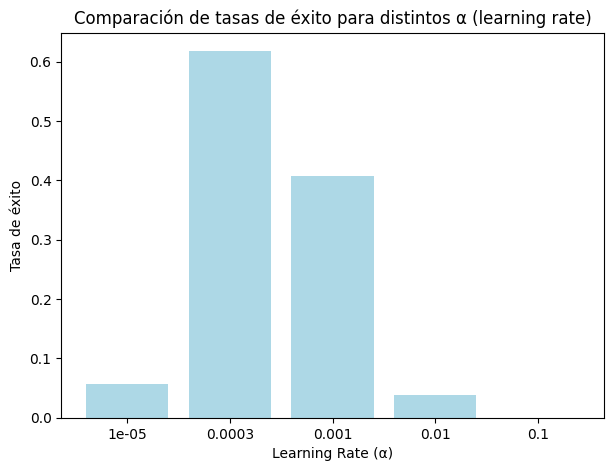

In [35]:
lrs = [0.00001, 0.0003, 0.001, 0.01, 0.1]
tasas_lr = []

for lr in lrs:
    print(f"\n⚙️ Entrenando DQN con lr = {lr}")
    agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n, lr=lr, gamma=0.95, epsilon=1.0)
    recompensas_dqn = agente_dqn.entrenar(env, episodios=2000)
    tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)
    tasas_lr.append(tasa_exito_dqn)

plt.figure(figsize=(7,5))
plt.bar([str(lr) for lr in lrs], tasas_lr, color='lightblue')
plt.title("Comparación de tasas de éxito para distintos α (learning rate)")
plt.xlabel("Learning Rate (α)")
plt.ylabel("Tasa de éxito")
plt.show()


#### Resultados:

La tasa de aprendizaje (alpha) controla cuánto se actualizan los valores o pesos del modelo después de cada experiencia. Si ponemos un alpha alto hacemos que se produscan cambios muys brusco y hace que el modelo aprenda rápido al principio pero después se estanque. Por otro lado un alpha muy bajo genera que el modelo aprenda muy lento o ni siquiera lo haga.

En los resultados del entrenamiento esto se puede ver con claridad para los alphas muy bajo (0.00001) y los alphas muy altos (0.01 y 0.1) donde el modelo no llega a obtener un buen desempeño. En cambio, para los valores intermedios de alpha (0.0003 y 0.001) el resultado fue más óptimo y equilibrado.



## Conlcusiones finales

Para este trabajo de aprendizaje automático 2, pude aprender e implementar el uso del aprendizaje por refuerzo, donde comparé tres diferentes modelos y analicé sus desempeños.

En mi entrenamiento de los modelos, pude aprender que un agente aleatorio no es una buena opción ya que su política es muy pobre y no le permite adaptarse, entoces toma decisiones sin aprender y no lográ alcanzar una mejora en su tasa de éxito.

Los modelos de Q learning tabular y DQN si tuvieron buenos resultados, confirmando que una buena política implementada junto con los parámetros adecuados pueden generar un buen desempeño. También hay una estabilidad mejor para el modelo DQN demostrando que su red neuronal le permite tener un resultado más robusto que genera un buen equilibrio de aprendizaje.

Por otro lado, la evaluación de diferentes valores de gamma y alpha me permitió comprender la sensibilidad de los modelos frente a estos hiperparámetros. Lo puedo relacionar un poco con el subajuste y sobreajuste, donde valores muy bajos o muy altos generan un rendimiento deficiente, mientras que valores intermedios logran un mejor equilibrio entre exploración, explotación y estabilidad del aprendizaje.

### Referencias:

Utilicé todos los apuntes de aprendizaje por refuerzo de la materia, sobre todo el notebook "PARTE_2_Intro_Qlearning_fuente_Reinforcement Learning" y el tutorial de pytorch (https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

También use CHAT-GPT para mejorar los bucles de entrenamiento para cada punto, le pedí que me ayude a generar un bucle que recorra los diferentes valores para los diferentes modelos.